Portfolio Optimization Project 


Import libraries

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta, timezone
import yfinance as yf 
from scipy.optimize import minimize

In [68]:
end_date = datetime.today()

In [69]:
start_date = end_date - timedelta(days = 7 * 365)
print (start_date)

2018-06-15 20:21:57.757714


In [70]:
adj_close_df = pd.DataFrame()

In [71]:

tickers = yf.Tickers("URA VOO QQQ BMO RSP NLR")
for ticker in tickers.tickers:
    stock_data = yf.download(ticker,start=start_date, end=end_date)
    adj_close_df[ticker] = stock_data['Close']
print(adj_close_df)

/var/folders/1r/jlk6s6nd0ss3h022myjjhb6w0000gn/T/ipykernel_56185/3388319966.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker,start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/1r/jlk6s6nd0ss3h022myjjhb6w0000gn/T/ipykernel_56185/3388319966.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker,start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/1r/jlk6s6nd0ss3h022myjjhb6w0000gn/T/ipykernel_56185/3388319966.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker,start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/1r/jlk6s6nd0ss3h022myjjhb6w0000gn/T/ipykernel_56185/3388319966.py:4: FutureWarning: YF.download() has 

                  URA         VOO         QQQ         BMO         RSP  \
Date                                                                    
2018-06-18  11.208097  227.245056  168.735474   60.032001   91.920700   
2018-06-19  10.968924  226.381424  168.257492   59.660194   91.548416   
2018-06-20  11.001915  226.790970  169.452515   59.745392   91.805489   
2018-06-21  10.820473  225.375290  167.980240   59.877060   91.273628   
2018-06-22  10.886452  225.775955  167.607452   60.233395   91.512955   
...               ...         ...         ...         ...         ...   
2025-06-09  35.180000  551.250000  530.700012  108.050003  178.720001   
2025-06-10  34.049999  554.390015  534.210022  107.849998  179.610001   
2025-06-11  35.869999  552.859985  532.409973  107.739998  179.100006   
2025-06-12  36.009998  554.950012  533.659973  108.370003  179.520004   
2025-06-13  36.130001  548.770020  526.960022  106.949997  177.350006   

                   NLR  
Date                    


Calculate LogNormal Returns for each ticker
Calculate Daily returns 
LognORMAL RETURNS ARE ADDITIVE

takes one days price and shifts and diveds by the previous day price 

In [72]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

Drops any NA values so any future calcs dont get messed up 

In [73]:
log_returns = log_returns.dropna()

In [74]:
print(log_returns)

                 URA       VOO       QQQ       BMO       RSP       NLR
Date                                                                  
2018-06-19 -0.021570 -0.003808 -0.002837 -0.006213 -0.004058  0.001001
2018-06-20  0.003003  0.001807  0.007077  0.001427  0.002804  0.000600
2018-06-21 -0.016629 -0.006262 -0.008726  0.002201 -0.005810 -0.003005
2018-06-22  0.006079  0.001776 -0.002222  0.005933  0.002619  0.013156
2018-06-25 -0.025318 -0.013939 -0.022788 -0.013726 -0.011006  0.001187
...              ...       ...       ...       ...       ...       ...
2025-06-09  0.044762  0.001071  0.001471 -0.002219  0.000168  0.022718
2025-06-10 -0.032648  0.005680  0.006592 -0.001853  0.004967 -0.025934
2025-06-11  0.052071 -0.002764 -0.003375 -0.001020 -0.002843  0.056840
2025-06-12  0.003895  0.003773  0.002345  0.005830  0.002342  0.001236
2025-06-13  0.003327 -0.011199 -0.012634 -0.013190 -0.012161 -0.002377

[1757 rows x 6 columns]


Calculate Covariance Matrix using Log Returns

we do times 252 to annualize this value and find the covariance and corelation between each of the securities in the portfolio

In [75]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

          URA       VOO       QQQ       BMO       RSP       NLR
URA  0.139566  0.041939  0.048790  0.045505  0.041700  0.065716
VOO  0.041939  0.041143  0.047166  0.038040  0.039798  0.031324
QQQ  0.048790  0.047166  0.061828  0.036440  0.041298  0.033436
BMO  0.045505  0.038040  0.036440  0.071020  0.042471  0.032390
RSP  0.041700  0.039798  0.041298  0.042471  0.042993  0.031814
NLR  0.065716  0.031324  0.033436  0.032390  0.031814  0.054160


Calculate Portfolio Performance Metrics

calculate risk - calculates the variance, a Measure of risk associated with a porftolio of assets. It combines the volatility of assets in the portfolio 

STANDARD DEVIATION FIRST

. T transposes - an array that is 1 row high and 5 columns wide transpose it so that it is 5 columns high and 1 row wide 

the @ symbl means we are mulitplying two arrays together

we return the sq rt of variance because standard deviation is truly the square root of variance

In [76]:
def standard_deviation(weights, cov_matrix): ##inputs 
    variance = weights.T @ cov_matrix @ weights  ##what does the @ symbol do?
    return np.sqrt(variance)

calculate the expected return

Key assumption is expected returns are based on historical returns

In [77]:
def portfolio_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

Calculate Sharpe Ratio 
=
(Expected Return - risk free rate)/ Standard deviation 

In [78]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return(portfolio_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix) #risk premium divided by standard deviation

Get the risk free rate 

Fed reserve api pull

In [79]:
from fredapi import Fred

#replace with my api key and connect to fed
fred = Fred(api_key='051d5809ddca97caac87dd597a0ddc35')
ten_year_treasury = fred.get_series('GS10')/100##divide by 100 to get percentage

#set the risk free rate
risk_free_rate = ten_year_treasury.iloc[-1]
print(risk_free_rate)

0.044199999999999996


define the function to minimize negative sharpe ratio 

In [80]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

set the constraints and bonds 

constraints make sure that the portfolio is the sum of the wieghts in the portfolio = 1
the bound is 0 lower and 5 upper 
0 means we cant go short or sell any assets - meaning we can only go long or purchase
5 means that we cant have more than 50% of our portfiolo in one single portfolio - this is for short time periods dont get tricked

In [81]:
consrtaints = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bounds =[(0,1) for i in range(len(tickers.tickers))]  #set bounds for each weight

set the initial weights 

dynamic function to set qual initial weights for all securities in portfolio 

In [82]:
initial_weights = np.array([1/len(tickers.tickers)] * len(tickers.tickers))
print(initial_weights)

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


optimize the weights to maxmize sharpe ratio 

SLQP stands for least square quadratic programming, a Numerical Optimaization technique for suitable for solving non linear optimzation problems with constarints

In [83]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=consrtaints, bounds=bounds)

get optimal weights 

.x is a way for us to acces those results 

In [84]:
optimal_weights = optimized_results.x

Analyze the optimal Portfolio 
display analytics of porfolio 

In [85]:
print("Optimal_weights")
for ticker, weight in zip(tickers.tickers, optimal_weights):
    print(f'{ticker}: {weight*100:.4f}%')

print()
optimal_portfolio_return = portfolio_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f'Expected annual return: {optimal_portfolio_return:.4f}')
print(f'Expected annual volatility: {optimal_portfolio_volatility:.4f}')
print(f'Sharpe ratio: {optimal_sharpe_ratio:.4f}')

Optimal_weights
URA: 3.1520%
VOO: 0.0000%
QQQ: 70.8937%
BMO: 0.0000%
RSP: 0.0000%
NLR: 25.9543%

Expected annual return: 0.1554
Expected annual volatility: 0.2245
Sharpe ratio: 0.4951


Display in a graph 

In [86]:
def simulate_random_portfolios(num_portfolios, log_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return_value = portfolio_return(weights, log_returns)
        portfolio_volatility = standard_deviation(weights, cov_matrix)
        sharpe_ratio_value = (portfolio_return_value - risk_free_rate) / portfolio_volatility
        results[0,i] = portfolio_return_value
        results[1,i] = portfolio_volatility
        results[2,i] = sharpe_ratio_value
    return results, weights_record  

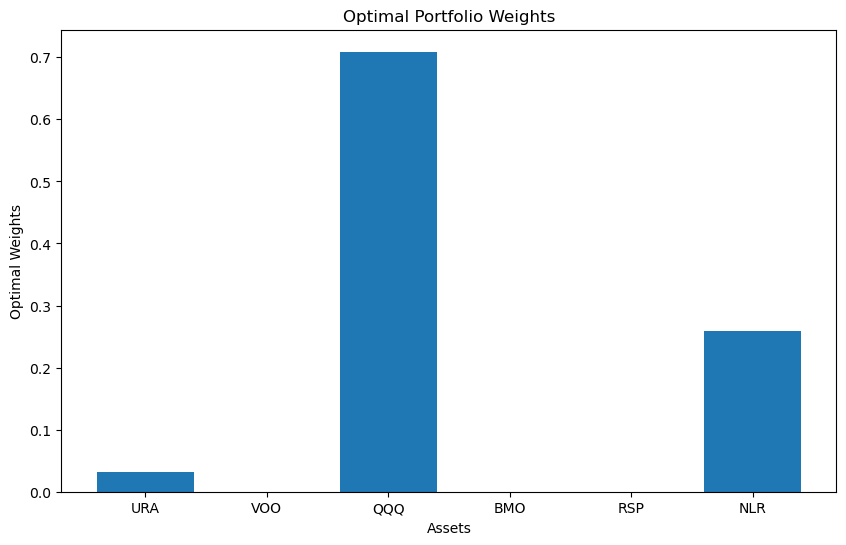

In [87]:
import matplotlib.pyplot as plt
tickers = ["URA", "VOO", "QQQ", "BMO", "RSP", "NLR"]  # Define tickers as a list of strings
plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)


plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')


plt.show()